Загружаем данные.

Последние семь дней (это просто продублированные значения из таблицы за последнюю известную дату - 8 дней назад).

Вам нужно спрогнозировать цену биткоина (Price) на последние семь дней.

In [1]:
! pip install -r requirements.txt --quiet

In [2]:
#!pip install -Iv etna[all] --quiet --quiet
#!pip install evaluate --quiet

In [3]:
from copy import deepcopy
import warnings

import os
import zipfile

import torch
import random
import pandas as pd
import numpy as np
#import seaborn as sns

from etna import SETTINGS
SETTINGS.torch_required=True

#import lightning.pytorch as pl # Instead of import pytorch_lightning as pl
#import pytorch_lightning as pl
#from pytorch_forecasting.data import TimeSeriesDataSet
#from pytorch_forecasting.data.encoders import EncoderNormalizer
#from pytorch_forecasting.data.encoders import NaNLabelEncoder
#from pytorch_forecasting.data.encoders import TorchNormalizer
#from torch.utils.data import DataLoader
#from pytorch_forecasting.models import DeepAR
#from pytorch_lightning import LightningModule

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from functools import lru_cache
from functools import partial

from typing import Optional
from typing import Iterable

from torch.optim import AdamW
from torch.utils.data import DataLoader as DataLoader

from datasets import load_dataset
from accelerate import Accelerator
#from evaluate import load

from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
    PretrainedConfig,
)


from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import (LinearPerSegmentModel, AutoARIMAModel, ElasticPerSegmentModel,
                         SARIMAXModel, LinearMultiSegmentModel, HoltWintersModel)

from etna.metrics import SMAPE, MAPE, MAE, MSE
from etna.models import CatBoostMultiSegmentModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder
from etna.models.nn import TFTModel, RNNModel, DeepARModel

from etna.transforms import DateFlagsTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import FourierTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.transforms import TrendTransform
#from etna.transforms import PytorchForecastingTransform

from etna.analysis import (
    plot_backtest,
    plot_residuals,
    acf_plot,
    get_residuals,
    plot_anomalies,
    stl_plot,
)

from etna.analysis.outliers import get_anomalies_density

warnings.filterwarnings("ignore")

In [4]:
from datetime import datetime
def log(data, msg='',label='MAE'):
    with open('log.txt', 'a') as f:
        f.write(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")} {label}={data} | {msg}\n')

In [5]:
NFOLDS = 2

In [6]:
path = "/kaggle/input/bitcoin-price-forecast/Bitcoin_kaggle.csv"
full_df = pd.read_csv("Bitcoin_kaggle.csv",
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

full_df.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-14,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-13,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-12,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-11,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-10,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-09,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-08,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%


In [7]:
df = full_df.iloc[7:]
df.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-07-07,"30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
2023-07-06,"29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
2023-07-05,"30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
2023-07-04,"30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
2023-07-03,"31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%
2023-07-02,"30,617.7","30,587.1","30,769.0","30,227.9",28.82K,0.10%
2023-07-01,"30,586.8","30,472.9","30,649.9","30,329.0",22.46K,0.37%
2023-06-30,"30,472.9","30,445.7","31,275.5","29,714.5",118.65K,0.09%
2023-06-29,"30,445.7","30,077.3","30,823.1","30,051.3",49.57K,1.22%


Преобразуем Price в нужный формат.

In [8]:
cols = ['Price', 'Open', 'High', 'Low']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x.replace(",","")) if x==x else x)
df['Vol.'] = df['Vol.'].replace({"K":"*1e3", "M":"*1e6", 'B':'*1e9'}, regex=True).map(pd.eval)
df = df.rename(columns={'Vol.':'Vol'})
#df['Vol.'] = df['Vol.'].apply(lambda x: float(x.replace('.','').replace('K','0').replace('M','0000').replace))
df['Vol']

Date
2023-07-07    46420.0
2023-07-06    90810.0
2023-07-05    43230.0
2023-07-04    42120.0
2023-07-03    56490.0
               ...   
2022-01-18    47320.0
2022-01-17    41440.0
2022-01-16    28660.0
2022-01-15    31440.0
2022-01-14    50500.0
Name: Vol, Length: 540, dtype: float64

In [9]:
df.rename(columns={'Price': 'target', 'Date':'timestamp'}, inplace=True)
df['segment']='main'
df['timestamp'] = df.index


In [10]:
df_target = TSDataset.to_dataset(df=df[["target", "segment", "timestamp"]])
df_target.dropna(inplace=True)
df_target

segment,main
feature,target
timestamp,
2022-01-14,43073.3
2022-01-15,43097.0
2022-01-16,43079.1
2022-01-17,42209.3
2022-01-18,42364.6
...,...
2023-07-03,31151.3
2023-07-04,30768.4


In [11]:
df_exog = TSDataset.to_dataset(df=df.drop(columns=["target", 'Change %']))
df_exog

segment        main                           
feature        High      Low     Open      Vol
timestamp                                     
2022-01-14  43435.1  41848.7  42562.2  50500.0
2022-01-15  43777.9  42586.1  43073.6  31440.0
2022-01-16  43462.0  42643.3  43079.2  28660.0
2022-01-17  43179.6  41559.4  43080.5  41440.0
2022-01-18  42674.2  41300.7  42209.9  47320.0
...             ...      ...      ...      ...
2023-07-03  31377.0  30581.5  30617.5  56490.0
2023-07-04  31326.5  30657.8  31152.0  42120.0
2023-07-05  30875.6  30233.3  30768.6  43230.0
2023-07-06  31463.6  29869.0  30512.8  90810.0
2023-07-07  30442.0  29757.4  29912.7  46420.0

[540 rows x 4 columns]

In [12]:
train_ts = TSDataset(df=df_target, df_exog=df_exog,freq="D")
train_ts

segment        main                                    
feature        High      Low     Open      Vol   target
timestamp                                              
2022-01-14  43435.1  41848.7  42562.2  50500.0  43073.3
2022-01-15  43777.9  42586.1  43073.6  31440.0  43097.0
2022-01-16  43462.0  42643.3  43079.2  28660.0  43079.1
2022-01-17  43179.6  41559.4  43080.5  41440.0  42209.3
2022-01-18  42674.2  41300.7  42209.9  47320.0  42364.6
...             ...      ...      ...      ...      ...
2023-07-03  31377.0  30581.5  30617.5  56490.0  31151.3
2023-07-04  31326.5  30657.8  31152.0  42120.0  30768.4
2023-07-05  30875.6  30233.3  30768.6  43230.0  30512.8
2023-07-06  31463.6  29869.0  30512.8  90810.0  29913.1
2023-07-07  30442.0  29757.4  29912.7  46420.0  30346.4

[540 rows x 5 columns]

In [13]:
arima = False

In [14]:

def set_seed(seed: int = 79):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [15]:
HORIZON = 7
if arima:
    model=AutoARIMAModel()
    pipeline = Pipeline(
        transforms=[
            LagTransform(in_column="target", lags=[14]),],
        model=AutoARIMAModel(maxiter=100),
        #model=SARIMAXModel(),
        horizon=HORIZON
    )
    metrics, forecast, _ = pipeline.backtest(
        ts=train_ts, metrics=[MAE()], n_folds=NFOLDS, aggregate_metrics=True
    )

    #model.fit(train_ts)
    log(metrics.iloc[0]['MAE'])
else:
    
    transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
    num_lags = 5
    transform_lag = LagTransform(
        in_column="target",
        lags=[HORIZON + i for i in range(num_lags)],
        out_column="target_lag",
    )
    lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]
    
    
    # Prepare model
    model_deepar = DeepARModel(
        encoder_length=HORIZON,
        decoder_length=HORIZON,
        trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
        lr=0.01,
        train_batch_size=64,
    )
    metrics = [SMAPE(), MAPE(), MAE()]

    pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON, transforms=[transform_lag, transform_date])

    #pipeline.fit(train_ts)

    # Make a forecast
    #forecast_ts = pipeline.forecast()
    metrics, forecast, _ = pipeline_deepar.backtest(train_ts, metrics=metrics, n_folds=NFOLDS, n_jobs=1)
    #metrics, forecast, _ = pipeline.backtest(
    #    ts=train_ts, metrics=[MAE()], n_folds=NFOLDS, aggregate_metrics=True
    #)

    #model.fit(train_ts)
    log(metrics.iloc[0]['MAE'])
    score = metrics["MAE"].mean()
    print(f"Average MAE for DeepAR: {score:.3f}")
metrics


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.4min
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s


Average MAE for DeepAR: 351.568


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s


,segment,SMAPE,MAPE,MAE,fold_number
0,main,0.576421,0.575027,175.080915,0
0,main,1.737977,1.718187,528.055804,1


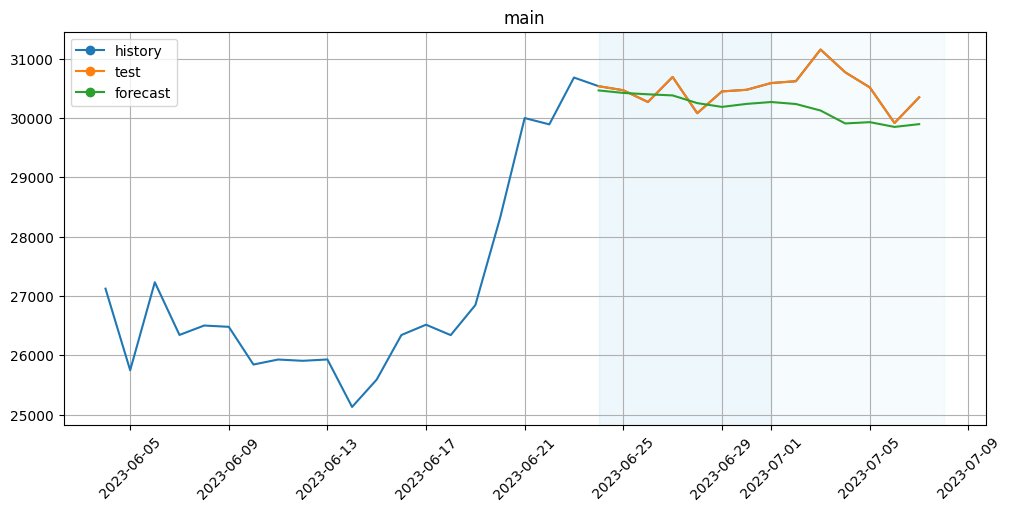

In [16]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=20)

In [17]:
#forecast_ARIMA = forecast
#forecast_ARIMA

Сохраним прогноз в файл и отправим на kaggle.

In [18]:
#forecast_ARIMA['main']['target']
#X_test.set_index('Date', inplace=True)

In [19]:
#X_test[['Price']][last:].to_csv("prediction_baseline.csv")

In [20]:
def print_logs():
    with open('log.txt', 'r') as f:
        for line in f.readlines():
            print(line.strip())

In [21]:
print_logs()

20230807 18:19:10 MAE=12.978722844044551
2023-08-07 18:19:44 MAE=12.978722844044551
2023-08-07 18:21:19 MAE=12.978722844044551
2023-08-07 18:22:46 MAE=11.911638501214583
2023-08-07 18:23:36 MAE=13.65869100219798
2023-08-07 18:23:58 MAE=12.965884461704158
2023-08-14 15:37:32 MAE=238.75066964285776 |
2023-08-14 15:44:29 MAE=1129.1114397321423 |
2023-08-14 16:42:47 MAE=1461.544196428571 |
2023-08-14 16:51:04 MAE=455.81316964285674 |
2023-08-14 16:58:00 MAE=430.5877232142853 |
2023-08-14 17:07:42 MAE=1049.1072544642852 |
2023-08-14 17:19:50 MAE=1129.1114397321423 |
2023-08-14 17:32:08 MAE=175.08091517857142 |


In [22]:
#model=HoltWintersModel()
model=model_deepar
pipeline = Pipeline(
    transforms=[
        LagTransform(in_column="target", lags=[14]),],
    #model=SARIMAXModel(),
    model=model,
horizon=7)
pipeline = pipeline_deepar
pipeline.fit(train_ts)

#future_ts = train_ts.make_future(future_steps=7, tail_steps=model.context_size)

#forecast_ts = pipeline.forecast(future_ts)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


Pipeline(model = DeepARModel(decoder_length = 7, encoder_length = 7, dataset_builder = PytorchForecastingDatasetBuilder(max_encoder_length = 7, min_encoder_length = 7, min_prediction_idx = None, min_prediction_length = None, max_prediction_length = 7, static_categoricals = [], static_reals = [], time_varying_known_categoricals = [], time_varying_known_reals = ['time_idx'], time_varying_unknown_categoricals = [], time_varying_unknown_reals = ['target'], variable_groups = {}, constant_fill_strategy = [], allow_missing_timesteps = True, lags = {}, add_relative_time_idx = True, add_target_scales = True, add_encoder_length = True, target_normalizer = GroupNormalizer(groups=['segment']), categorical_encoders = {}, scalers = {}, ), train_batch_size = 64, test_batch_size = 64, lr = 0.01, cell_type = 'LSTM', hidden_size = 10, rnn_layers = 2, dropout = 0.1, loss = NormalDistributionLoss(), trainer_params = {'max_epochs': 150, 'gpus': 0, 'gradient_clip_val': 0.1, 'logger': []}, quantiles_kwargs =

In [23]:
forecast_ts = pipeline.forecast()

In [24]:
forecast_df = forecast_ts.to_pandas()['main'][['target']]
forecast_df


feature,target
timestamp,
2023-07-08,30402.107422
2023-07-09,30368.322266
2023-07-10,30348.242188
2023-07-11,30540.410156
2023-07-12,30735.033203
2023-07-13,30853.369141
2023-07-14,30946.546875


In [25]:
forecast_df = forecast_df.rename(columns={'target':'Price'})

In [26]:
forecast_df['Date'] = forecast_df.index
forecast_df.set_index('Date', inplace=True)

In [27]:
forecast_df.to_csv("prediction_baseline.csv")

In [28]:
forecast_ts.to_pandas()['main']['target']

timestamp
2023-07-08    30402.107422
2023-07-09    30368.322266
2023-07-10    30348.242188
2023-07-11    30540.410156
2023-07-12    30735.033203
2023-07-13    30853.369141
2023-07-14    30946.546875
Freq: D, Name: target, dtype: float64

<Axes: xlabel='Date'>

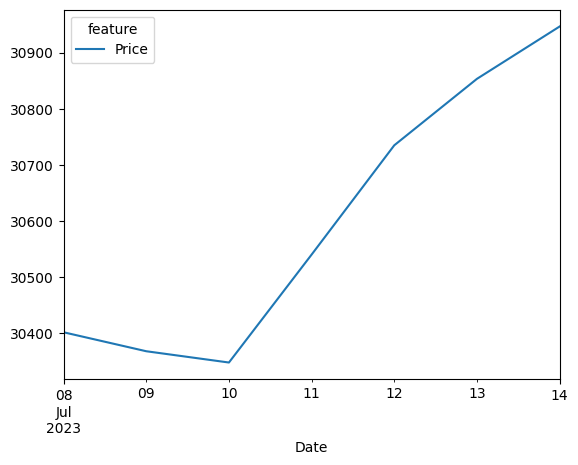

In [29]:
forecast_df.plot()